##### 문제 7-1 : LangGraph ReAct Agent 실습 연습문제 (Vector DB + Tool 연동) 

In [1]:
from dotenv import load_dotenv
load_dotenv()

import re
import os, json

from textwrap import dedent
from pprint import pprint

import uuid

import warnings
warnings.filterwarnings("ignore")

In [2]:
from langchain_community.vectorstores import FAISS
from langchain_ollama  import OllamaEmbeddings
from langchain_core.tools import tool
from typing import List

#embeddings_model = OllamaEmbeddings(model="qwen2.5:1.5b") 
embeddings_model = OllamaEmbeddings(model="bge-m3:latest")

# menu db 벡터 저장소 로드
menu_db = FAISS.load_local(
    "../db/cafe_db", 
    embeddings_model, 
    allow_dangerous_deserialization=True
)

# Tool 정의 
@tool
def search_menu(query: str) -> List[str]:
    """카페 메뉴에서 정보를 검색합니다."""
    docs = menu_db.similarity_search(query, k=6)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}"/>\n{doc.page_content}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 메뉴 정보를 찾을 수 없습니다."

In [3]:
from langchain_community.tools import TavilySearchResults


# Tool 정의 
@tool
def search_web(query: str) -> List[str]:
    """데이터베이스에 존재하지 않는 정보 또는 최신 정보를 인터넷에서 검색합니다."""

    tavily_search = TavilySearchResults(max_results=3)
    docs = tavily_search.invoke(query)

    formatted_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in docs
        ]
    )

    if len(docs) > 0:
        return formatted_docs
    
    return "관련 정보를 찾을 수 없습니다."

In [4]:
from langchain_openai import ChatOpenAI

# LLM 모델 
llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)
print(llm.model_name)

# 도구 목록
tools = [search_menu, search_web]
print(type(search_menu))

# 모델에 도구를 바인딩
llm_with_tools = llm.bind_tools(tools=tools)
print(type(llm_with_tools))

gpt-4o-mini
<class 'langchain_core.tools.structured.StructuredTool'>
<class 'langchain_core.runnables.base.RunnableBinding'>


In [24]:
from langchain_core.messages import HumanMessage

# 도구 호출 ( Vector DB )
tool_call = llm_with_tools.invoke([HumanMessage(content=f"아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")])

# 결과 출력
pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query": "아메리카노"}',
                              'name': 'search_menu'},
                 'id': 'call_Xgmcqr0WPPmXm3lONogNlC3t',
                 'index': 0,
                 'type': 'function'},
                {'function': {'arguments': '{"query": "아이스 아메리카노"}',
                              'name': 'search_menu'},
                 'id': 'call_vUEN8O0agCx3x3mUTRJ0y4mu',
                 'index': 1,
                 'type': 'function'}]}


In [25]:
from langgraph.prebuilt import ToolNode

# 도구 노드 정의 
tools = [search_menu, search_web]
tool_node = ToolNode(tools=tools)

# 도구 호출 
tool_call = llm_with_tools.invoke([HumanMessage(content=f"아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")])

pprint(tool_call.additional_kwargs)

{'tool_calls': [{'function': {'arguments': '{"query": "아메리카노"}',
                              'name': 'search_menu'},
                 'id': 'call_0Sq4Vf1RJ3qEmQEzNDYNgCvs',
                 'index': 0,
                 'type': 'function'},
                {'function': {'arguments': '{"query": "아이스 아메리카노"}',
                              'name': 'search_menu'},
                 'id': 'call_y7iyoMnYozIXzdZAj8ITqgso',
                 'index': 1,
                 'type': 'function'}]}


In [26]:
# 도구 호출 결과를 메시지로 추가하여 실행 
# 도구 호출 
tool_call_result = llm_with_tools.invoke("아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")
results = tool_node.invoke({"messages": [tool_call_result]})

# 실행 결과 출력하여 확인 
for result in results['messages']:
    print(result.content)
    print('**** --------------------------- ****')

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
3. 카푸치노
   • 가격: ₩5,000
   • 주요 원료: 에스프레소, 스팀 밀크, 우유 거품
   • 설명: 에스프레소, 스팀 밀크, 우유 거품이 1:1:1 비율로 구성된 이탈리아 전통 커피입니다. 진한 커피 맛과 부드러운 우유 거품의 조화가 일품이며, 계피 파우더를 뿌려 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스

<class 'langgraph.graph.state.CompiledStateGraph'>


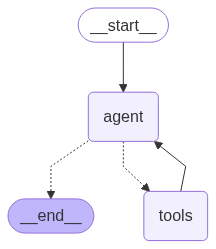

In [28]:
from IPython.display import Image, display
from langgraph.prebuilt import create_react_agent  # 미리 정의된 에이전트 생성 함수

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm, 
    tools=tools, 
)

"""
[create_react_agent() 설명]
1. 역할: 
   - 'ReAct(Reasoning + Acting)' 프레임워크 기반의 자동화 에이전트 생성
   - 에이전트가 '생각(Reasoning)'과 '행동(Acting)'을 반복하며 문제 해결

2. 동작 방식:
   - 사용자 질문 → LLM이 '생각' → 필요한 도구 선택 → 도구 실행 → 결과 분석 → 최종 응답
   - 이 과정을 자동으로 반복하는 그래프 구조 생성

3. 예시 시나리오:
   "오늘 서울 날씨 알려줘" 질문 시:
   1. 날씨 API 도구 사용 필요 판단
   2. 날씨 API 호출
   3. 결과 해석 후 사용자 응답 생성
"""

print(type(graph)) # <class 'langgraph.graph.StateGraph'>

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [29]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")]}

"""
[실행 과정]
1. inputs → 그래프 시작 노드로 전달
2. 각 노드에서 'messages' 리스트 업데이트
3. 최종 상태 반환 (모든 메시지 포함)
"""
messages = graph.invoke(inputs)

for m in messages['messages']:
    print(type(m), m)
    m.pretty_print()

<class 'langchain_core.messages.human.HumanMessage'> content='아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.' additional_kwargs={} response_metadata={} id='bfcf6964-9815-42f1-bcfe-05f5b94fd06f'
================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
<class 'langchain_core.messages.ai.AIMessage'> content='' additional_kwargs={'tool_calls': [{'index': 0, 'id': 'call_grNTW2zcBt972yVdNAV8ruCs', 'function': {'arguments': '{"query": "아메리카노"}', 'name': 'search_menu'}, 'type': 'function'}, {'index': 1, 'id': 'call_OSjlINmLgdUnSmBtwu6wHLMn', 'function': {'arguments': '{"query": "아이스 아메리카노"}', 'name': 'search_menu'}, 'type': 'function'}]} response_metadata={'finish_reason': 'tool_calls', 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'service_tier': 'default'} id='run--81b5113a-dd95-4e77-b9a1-dafe30928224-0' tool_calls=[{'name': 'search_menu', 'args': {'query': '아메리카노'}, 'id': 'call_grNTW2zcBt972yVdNAV8ruCs', 'type': 

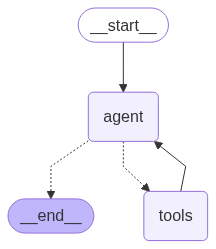

In [30]:
from langgraph.prebuilt import create_react_agent
from IPython.display import Image, display
from langchain_core.messages import SystemMessage
from textwrap import dedent  # 들여쓰기 자동 조정

# 시스템 프롬프트
# system_prompt = dedent("""
# You are an AI assistant designed to answer human questions. 
# You can use the provided tools to help generate your responses.

# Follow these steps to answer questions:
#     1. Carefully read and understand the question.
#     2. Use the provided tools to obtain necessary information.
#     3. Immediately after using a tool, cite the source using the format below.
#     4. Construct an accurate and helpful answer using the tool outputs and citations.
#     5. Provide the final answer when you determine it's complete.

# When using tools, follow this format:
#     Action: tool_name
#     Action Input: input for the tool

# Immediately after receiving tool output, cite the source as follows:
#     [Source: tool_name | document_title/item_name | url/file_path]

# For example:
#     Action: search_menu
#     Action Input: 아메리카노
    
#     (After receiving tool output)
#     [Source: search_menu | 아메리카노 | ../data/cafe_menu_data.txt]
#     아메리카노에 대한 정보는 다음과 같습니다...

#     Action: search_web
#     Action Input: History of AI

#     (After receiving tool output)
#     [Source: search_web | AI History | https://en.wikipedia.org/wiki/History_of_artificial_intelligence]
#     AI의 역사는 다음과 같이 요약됩니다...

# If tool use is not necessary, answer directly.

# Your final answer should be clear, concise, and directly related to the user's question. 
# Ensure that every piece of factual information in your response is accompanied by a citation.

# Remember: ALWAYS include these citations for all factual information, tool outputs, and referenced documents in your response. 
# Do not provide any information without a corresponding citation.
# """)

# 시스템 프롬프트 (한글 버전)
system_prompt = dedent("""
당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_menu | 아메리카노 | ../data/cafe_menu_data.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성
""")

# ReAct 에이전트 그래프 생성
graph = create_react_agent(
    llm,        # 언어 모델 (예: ChatOpenAI 인스턴스)
    tools=tools,   # 사용 가능한 도구 리스트
    #state_modifier=system_prompt,
    #system_message=SystemMessage(content=system_prompt),
    )

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# 그래프 실행
messages = [
        SystemMessage(content=system_prompt),   # 시스템 프롬프트 설정 (AI의 행동 지침)
        HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")  # 사용자 질문
    ]

# 그래프 실행 (SystemMessage 포함)
messages = graph.invoke({"messages": messages})
"""
[실행 과정]
1. SystemMessage를 먼저 처리 → AI의 행동 규칙 설정
2. HumanMessage 처리 → 질문 분석 및 도구 사용 결정
3. 필요한 경우 tools 리스트의 도구들 자동 호출
4. 최종 응답 생성
"""

for m in messages['messages']:
    m.pretty_print()

"""
    [출력 예시]
    System: (시스템 프롬프트 내용 요약)...
    Human: 아메리카노의 가격은 얼마인가요?
    AI: [출처: cafe_db | 아메리카노 | ../db/menu.csv] 
        아메리카노는 4,500원입니다.
    """    


================================ System Message ================================


당신은 사용자 질문에 답변하는 AI 어시스턴트입니다.  
제공된 도구들을 활용해 정확한 정보를 전달해야 합니다.

[작동 원칙]
1. 질문 이해: 사용자의 질문을 정확히 파악하세요
2. 도구 활용: 필요한 정보는 반드시 제공된 도구로 조회
3. 출처 명시: 도구 사용 후 즉시 아래 형식으로 출처 표기
4. 답변 구성: 도구 결과와 출처를 포함해 명확히 답변
5. 완성 판단: 충분한 정보가 모이면 최종 답변 제공

[도구 사용 형식]
액션: 도구_이름  
액션 입력: 도구에_넘길_입력값  

[출처 표기 형식]
[출처: 도구_이름 | 문서_제목/항목명 | URL/파일경로]

[예시 1 - 메뉴 검색]
액션: search_menu  
액션 입력: 아메리카노  

(도구 실행 후)  
[출처: search_menu | 아메리카노 | ../data/cafe_menu_data.txt]  
아메리카노 정보: 아메리카노 4,500원...

[예시 2 - 웹 검색]  
액션: search_web  
액션 입력: AI 역사  

(도구 실행 후)  
[출처: search_web | AI 역사 | https://ko.wikipedia.org/wiki/인공지능]  
AI 역사는 1950년대부터...

[주의사항]
1. 도구가 필요없는 질문은 직접 답변
2. 모든 사실 정보는 반드시 출처 동반
3. 출처 없이는 어떠한 정보도 제공하지 말 것
4. 최종 답변은 질문과 직접 관련된 명확한 내용으로 구성

================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ============================

'\n    [출력 예시]\n    System: (시스템 프롬프트 내용 요약)...\n    Human: 아메리카노의 가격은 얼마인가요?\n    AI: [출처: cafe_db | 아메리카노 | ../db/menu.csv] \n        아메리카노는 4,500원입니다.\n    '

<class 'langgraph.graph.state.CompiledStateGraph'>


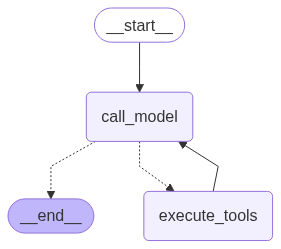

In [40]:
from langgraph.graph import MessagesState, StateGraph, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from IPython.display import Image, display

# LangGraph MessagesState 사용
class GraphState(MessagesState):
    pass

# 노드 구성 
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

def should_continue(state: GraphState):
    last_message = state["messages"][-1]
    # 도구 호출이 있으면 도구 실행 노드로 이동
    if last_message.tool_calls:
        return "execute_tools"
    # 도구 호출이 없으면 답변 생성하고 종료 
    return END

# 그래프 구성
builder = StateGraph(GraphState)
builder.add_node("call_model", call_model)
builder.add_node("execute_tools", ToolNode(tools))

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model", 
    should_continue,
    {
        "execute_tools": "execute_tools",
        END: END
    }
)
builder.add_edge("execute_tools", "call_model")

graph = builder.compile()
print(type(graph))

# 그래프 출력 
display(Image(graph.get_graph().draw_mermaid_png()))

In [41]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_H4UTmDHC5fL3MHNatHGZB29l)
 Call ID: call_H4UTmDHC5fL3MHNatHGZB29l
  Args:
    query: 아메리카노
  search_menu (call_5zswEZOIuVCzK8P0Hi138MaO)
 Call ID: call_5zswEZOIuVCzK8P0Hi138MaO
  Args:
    query: 아이스 아메리카노
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Documen

In [42]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_HGvVk3H8hHrof0UzxEDasLPO)
 Call ID: call_HGvVk3H8hHrof0UzxEDasLPO
  Args:
    query: 라떼
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
4. 바닐라 라떼
   • 가격: ₩6,000
   • 주요 원료: 에스프레소, 스팀 밀크, 바닐라 시럽
   • 설명: 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
8. 녹차 라떼
   • 가격: ₩5,800
   • 주요 원료: 말차 파우더, 스팀 밀크, 설탕
   • 설명: 고급 말차 파우더와 부드러운 스팀 밀크로 만든 건강한 음료입니다. 녹차의 은은한 쓴맛과 우유의 부드러움이 조화를 이루며, 항산화 성분이 풍부합니다. 달콤함 조절이 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유

In [43]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_2Vz1eEwWID1jG2SDmauZvrhL)
 Call ID: call_2Vz1eEwWID1jG2SDmauZvrhL
  Args:
    query: 티라미수
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
5. 카라멜 마키아토
   • 가격: ₩6,500
   • 주요 원료: 에스프레소, 스팀 밀크, 카라멜 시럽, 휘핑크림
   • 설명: 스팀 밀크 위에 에스프레소를 부어 만든 후 카라멜 시럽과 휘핑크림으로 마무리한 달콤한 커피입니다. 카라멜의 진한 단맛과 커피의 깊은 맛이 조화를 이루며, 시각적으로도 아름다운 층을 형성합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요

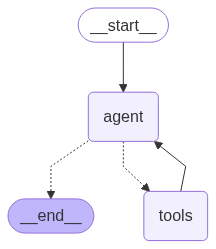

In [34]:
from langgraph.prebuilt import tools_condition

# 노드 함수 정의
def call_model(state: GraphState):
    system_message = SystemMessage(content=system_prompt)
    messages = [system_message] + state['messages']
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}

# 그래프 구성
builder = StateGraph(GraphState)

builder.add_node("agent", call_model)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "agent")

# tools_condition을 사용한 조건부 엣지 추가
builder.add_conditional_edges(
    "agent",
    tools_condition,
)

builder.add_edge("tools", "agent")

graph = builder.compile()

# 그래프 출력
display(Image(graph.get_graph().draw_mermaid_png()))

In [35]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

아메리카노와 아이스 아메리카노의 차이점과 가격을 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_MC6vr5KQztafrRUOyGekY2fN)
 Call ID: call_MC6vr5KQztafrRUOyGekY2fN
  Args:
    query: 아메리카노
  search_menu (call_w8PXIgSreNNSsLfRAUWOUM9y)
 Call ID: call_w8PXIgSreNNSsLfRAUWOUM9y
  Args:
    query: 아이스 아메리카노
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 뜨거운 물
   • 설명: 진한 에스프레소에 뜨거운 물을 더해 만든 클래식한 블랙 커피입니다. 원두 본연의 맛을 가장 잘 느낄 수 있으며, 깔끔하고 깊은 풍미가 특징입니다. 설탕이나 시럽 추가 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소, 차가운 물, 얼음
   • 설명: 진한 에스프레소에 차가운 물과 얼음을 넣어 만든 시원한 아이스 커피입니다. 깔끔하고 시원한 맛이 특징이며, 원두 본연의 풍미를 느낄 수 있습니다. 더운 날씨에 인기가 높습니다.
</Document>

---

<Documen

In [36]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

라떼 종류에는 어떤 메뉴들이 있고 각각의 특징은 무엇인가요?
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_ISSVEo8N6OfC0wnnDSTZRHoe)
 Call ID: call_ISSVEo8N6OfC0wnnDSTZRHoe
  Args:
    query: 라떼
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
4. 바닐라 라떼
   • 가격: ₩6,000
   • 주요 원료: 에스프레소, 스팀 밀크, 바닐라 시럽
   • 설명: 카페라떼에 달콤한 바닐라 시럽을 더한 인기 메뉴입니다. 바닐라의 달콤함과 커피의 쌉싸름함이 조화롭게 어우러지며, 휘핑크림 토핑으로 더욱 풍성한 맛을 즐길 수 있습니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
8. 녹차 라떼
   • 가격: ₩5,800
   • 주요 원료: 말차 파우더, 스팀 밀크, 설탕
   • 설명: 고급 말차 파우더와 부드러운 스팀 밀크로 만든 건강한 음료입니다. 녹차의 은은한 쓴맛과 우유의 부드러움이 조화를 이루며, 항산화 성분이 풍부합니다. 달콤함 조절이 가능합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유

In [37]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

디저트 메뉴 중에서 티라미수에 대해 자세히 설명해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_GktwJd6plXtaszBxkRXc8o7K)
 Call ID: call_GktwJd6plXtaszBxkRXc8o7K
  Args:
    query: 티라미수
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
10. 티라미수
    • 가격: ₩7,500
    • 주요 원료: 마스카포네 치즈, 에스프레소, 레이디핑거, 코코아 파우더
    • 설명: 이탈리아 전통 디저트로 마스카포네 치즈와 에스프레소에 적신 레이디핑거를 층층이 쌓아 만들었습니다. 부드럽고 달콤한 맛이 특징이며, 코코아 파우더로 마무리하여 깊은 풍미를 자랑합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
5. 카라멜 마키아토
   • 가격: ₩6,500
   • 주요 원료: 에스프레소, 스팀 밀크, 카라멜 시럽, 휘핑크림
   • 설명: 스팀 밀크 위에 에스프레소를 부어 만든 후 카라멜 시럽과 휘핑크림으로 마무리한 달콤한 커피입니다. 카라멜의 진한 단맛과 커피의 깊은 맛이 조화를 이루며, 시각적으로도 아름다운 층을 형성합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
9. 아이스 아메리카노
   • 가격: ₩4,500
   • 주요

In [39]:
# 그래프 실행
inputs = {"messages": [HumanMessage(content="4500원에서 7500원 사이의 카페 메뉴를 한가지 추천해주고 그 메뉴에 대해서 설명해주세요.")]}
messages = graph.invoke(inputs)

for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

4500원에서 7500원 사이의 카페 메뉴를 한가지 추천해주고 그 메뉴에 대해서 설명해주세요.
================================== Ai Message ==================================
Tool Calls:
  search_menu (call_1sOHwkVvUuc6uRy1K8vlLw7d)
 Call ID: call_1sOHwkVvUuc6uRy1K8vlLw7d
  Args:
    query: 4500원에서 7500원 사이
================================= Tool Message =================================
Name: search_menu

<Document source="../data/cafe_menu_data.txt"/>
7. 프라푸치노
   • 가격: ₩7,000
   • 주요 원료: 에스프레소, 우유, 얼음, 휘핑크림
   • 설명: 에스프레소와 우유, 얼음을 블렌더에 갈아 만든 시원한 음료입니다. 부드럽고 크리미한 질감이 특징이며, 휘핑크림을 올려 달콤함을 더했습니다. 여름철 인기 메뉴입니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
2. 카페라떼
   • 가격: ₩5,500
   • 주요 원료: 에스프레소, 스팀 밀크
   • 설명: 진한 에스프레소에 부드럽게 스팀한 우유를 넣어 만든 대표적인 밀크 커피입니다. 크리미한 질감과 부드러운 맛이 특징이며, 다양한 시럽과 토핑 추가가 가능합니다. 라떼 아트로 시각적 즐거움도 제공합니다.
</Document>

---

<Document source="../data/cafe_menu_data.txt"/>
1. 아메리카노
   • 가격: ₩4,500
   • 주요 원료: 에스프레소